## Loading Libraries

In [ ]:
# Author: Julio Sierra
# PI: Dr. Chris Wilson
# Title: Respiratory Data Analysis
# Created: December 09, 2022
# This version: April 19, 2024
# Acknowledgements: Nicholas Iwakoshi for all the help with Python

# Parameters: 
#          1. Input labchart exported .txt file to filepath_in
#          2. Change 'filename' to desired name
#          3. Modify filepath out to desired output location
# Results: 
#          1. Plots at various points to track analysis
#          2. CSV file containing all desired values in 'dct' to specified path

import pandas as pd
import numpy as np
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import signal, stats
from scipy.fft import fft,fftfreq
from scipy.signal import find_peaks, peak_widths, detrend, butter, welch
from scipy.ndimage import shift
from scipy.stats import zscore, entropy as ent
from scipy.interpolate import interp1d
import scipy.integrate as integrate 
import csv
import time
from statistics import mean

from hrvanalysis import preprocessing, extract_features, plot, plot_distrib, plot_poincare
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values, get_time_domain_features, get_frequency_domain_features, plot_psd

import pyhrv.nonlinear as nl
import pyhrv.time_domain as td


## Load file + create dataframe

In [552]:
# Convert 'peaks' x-axis location values to 'Time' axis  
def index_to_Time(Time, indices):
    "interpolate the values from signal.peak_widths to Time"
    ind = np.arange(len(Time))
    f = interp1d(ind,Time)
    return f(indices)

# 'datestr' stores current date in YYYY-MM-DD- format
datestr = time.strftime("%Y-%m-%d")

# Import file; Change \ to \\ for filepaths 
filepath_in = "C:\\Users\\vungo\\Desktop\\EMG_Data_5-13-2025\\C57_S1S2\\cut_data\\valid_data\\620_09-25-2024\\620_09-25-2024_cut_G.txt"
filename = "620_09-25-2024_cut_G"
# 'filename' will be used to identify output file; REMOVE FILETYPE (e.g. .txt); add initials if needed
filepath = "C:\\Users\\vungo\\Desktop\\EMG_Data_5-13-2025\\C57_S1S2\\python_output"

df = pd.read_csv(filepath_in, encoding = 'unicode_escape', sep = r"\s+", header = None, skiprows = 6, names = ['Time', 'ECG'])

df_detrended = signal.detrend(df.ECG)
df_detrended = df_detrended + df['ECG'].mean()
df['Detrended_ECG'] = df_detrended

Time = df['Time']
ECG = df['Detrended_ECG']
#ECG_abs = abs(ECG)
N = len(ECG)

# Sampling Rate Calculation
fs = np.round(1/(Time[1]-Time[0]))

# Divide length by sampling rate
recording_length = np.round((len(df)/fs))

In [576]:
df

,Time,ECG,Detrended_ECG
0,227.575,0.055847,0.056459
1,227.580,0.109253,0.109864
2,227.585,1.271973,1.272584
3,227.590,0.589905,0.590516
4,227.595,0.247193,0.247803
...,...,...,...
8848,271.815,0.059509,0.058898
8849,271.820,0.010376,0.009765
8850,271.825,0.097656,0.097045
8851,271.830,0.135498,0.134887


## Filtering and RR-peaks 

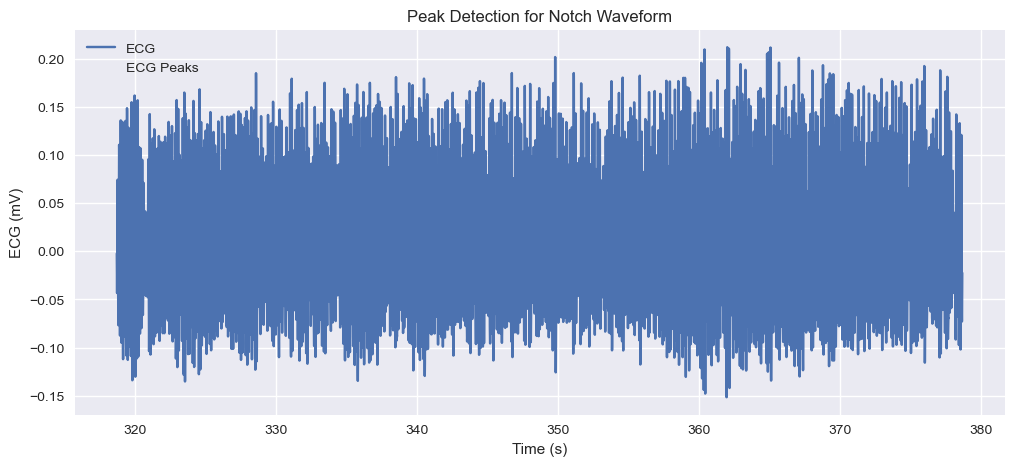

In [553]:
# Cardiac rate reference:
# Simultaneous monitoring of mouse respiratory and cardiac rates through a single precordial electrode (Sato et al., 2018)

# Notch filter at 60 Hz
b, a = signal.iirnotch(60.0, 30, fs)
ECG_RR = signal.filtfilt(b, a, ECG)

# Bandpass Filter for cardiac power
Wn = [7, 15]  # Filter cutoff frequency, in Hz
d, c = butter(2, Wn, btype='bandpass', fs=fs)
ECG_RR = signal.filtfilt(d, c, ECG_RR)

# Find R-peaks for filtered ECG , default values prominence = 0.3, distance = 10
peaks, _ = find_peaks(ECG, prominence=.3, distance=10)
peaks_RR, _ = find_peaks(ECG_RR, prominence=.3, distance=10)



# Plot Original and Filtered ECG
plt.close()

plt.figure(figsize=(12,5))
#plt.xlim(800, 803)
# this was changed ^ -HV
plt.plot(Time, ECG_RR)
plt.plot(Time[peaks_RR], ECG_RR[peaks_RR], "xr")
plt.legend(['ECG', 'ECG Peaks'])
plt.title("Peak Detection for Notch Waveform")
plt.xlabel("Time (s)")
plt.ylabel("ECG (mV)")
plt.show()

Time_peak_RR = pd.DataFrame(Time[peaks_RR], columns=["Time"])
ECG_peak_RR = pd.DataFrame(ECG_RR[peaks_RR], columns=["ECG (mV)"])

## Data Analysis for RR-intervals


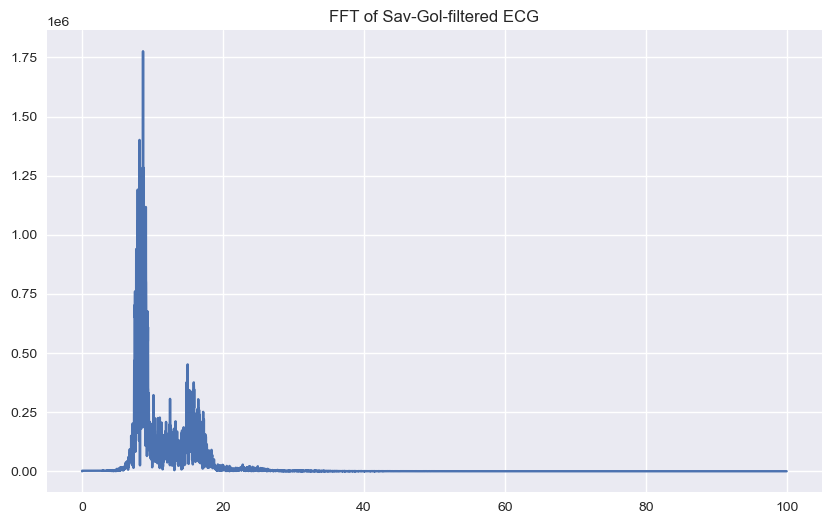

0 outliers were replaced with the median
9 ectopic beat(s) have been deleted with malik rule.


In [554]:
arr = peaks_RR.astype('float')
arr = arr[arr != 0]
Time_peaks_RR = extract_features.get_time_domain_features(arr)

## FFT CONVERSION AND PLOT

# Outlier removal
# Removes everything that's greater than a z-score of 3
# Requires your dataset to be detrended
# This method of outlier removal can be improved because it can result in false negatives
outliers = len(ECG_RR) - len(ECG_RR[(np.abs(stats.zscore(ECG_RR)) < 3)])

# This needs to be change to be more accurate, since currently it's just a guess
height = ECG_RR.mean() + ((ECG_RR.max() - ECG_RR.min())/4) # Divide by 4 to account for lower amplitude peaks
distance = 100 # 100 data points in between peaks should be enough to filter out smaller peaks
fft_data = np.subtract(ECG_RR,np.average(ECG_RR))
y_fft = fft(fft_data)
T = 1.0/fs
x_fft = fftfreq(N, T)[:N//2]

# Plotting FFT Plot of SG-Filtered ECG
plt.close()
plt.figure(figsize=(10,6))
fft_plt = plt.plot(x_fft, N * np.abs(y_fft[0:N//2]))
plt.title("FFT of Sav-Gol-filtered ECG")
#plt.grid()
plt.savefig(filepath + datestr + "-JS-" + filename + "_RR_fft_plot.svg", format = "svg")
plt.show()

# Finding the R-R Intervals and Running Calculations
RR_ind = np.diff(peaks_RR)
rr = RR_ind.copy()
z_score = zscore(rr)
RR_ind[np.abs(z_score) > 3] = np.median(rr)
print('{} outliers were replaced with the median'.format(sum(map(lambda x,y: bool(x-y),rr,RR_ind))))
ect_ind = remove_ectopic_beats(RR_ind)
nn_ind = interpolate_nan_values(rr_intervals=ect_ind)

## ADJUSTING THE FREQUENCY BANDS TO WHAT HAS BEEN FOUND IN MICE

#(lf and hf from Gehrmann, J. et al. Phenotypic screening for heart rate variability in the mouse. American Journal of Physiology-Heart and Circulatory Physiology 279, H733–H740 (2000).)
freq_dom_dct = extract_features.get_frequency_domain_features(RR_ind, sampling_frequency = fs, 
                                                  vlf_band = (.003, .4), 
                                                  lf_band = (.4, 1.5), 
                                                  hf_band = (1.5, 4))

##CALCULATING ENTROPIES AND POINT CARE PLOT VALUES 

#pcp_dct = extract_features.get_poincare_plot_features(arr)
#sampen_dct = extract_features.get_sampen(arr)
#nn6, pnn6 = td.nnXX(nni = arr, threshold = 6)
#nn6 and pnn6 because thats what it is for mice, needs to be double-checked form literature 
#nl_tuple = nl.nonlinear(nni = arr)
#ellipse_area = nl_tuple[4]
#sampen = nl_tuple[5]
#ShannEnt = ent(nn_ind)
#plt.close()

## Dictionary storing RR-interval values output to CSV file

In [555]:
result_dct1 = {'FileName' : filename,
            'RecordingLength' : recording_length,
            'SamplingFreq' : fs,
            'Height' : height,
            'Distance' : distance,
            'Raw_Zscore_Outliers' : outliers,
            'No_of_RR_Intervals' : len(arr),
            'Mean_NNI' : Time_peaks_RR['mean_nni'],
            'Median_NNI' : Time_peaks_RR['median_nni'],
            #'NN6' : nn6,
            #'PNN6' : pnn6,
            'SDNN' : Time_peaks_RR['sdnn'],
            'SDSD' : Time_peaks_RR['sdsd'],
            'RMSSD' : Time_peaks_RR['rmssd'],
            'CVSD' : Time_peaks_RR['cvsd'],
            'CVNNI' : Time_peaks_RR['cvnni'],
            'Mean_HR' : Time_peaks_RR['mean_hr'],
            'Max_HR' : Time_peaks_RR['max_hr'],
            'Min_HR' : Time_peaks_RR['min_hr'],
            'SD_HR' : Time_peaks_RR['std_hr'],
            'LF' : freq_dom_dct['lf'],
            'HF' : freq_dom_dct['hf'],
            'LF/HF_Ratio' : freq_dom_dct['lf_hf_ratio'],
            'LFnu' : freq_dom_dct['lfnu'],
            'HFnu' : freq_dom_dct['hfnu'],
            'Total_Power' : freq_dom_dct['total_power'],
            'VLF' : freq_dom_dct['vlf'],
            #'SD1' : pcp_dct['sd1'],
            #'SD2' : pcp_dct['sd2'],
            #'SD1/SD2_Ratio' : pcp_dct['ratio_sd2_sd1'],
            #'Ellipse_Area' : ellipse_area,
            #'SampEn' : sampen
            #'ShannEn' : ShannEnt
            }

## Poincare and Welch Plots for RR-intervals

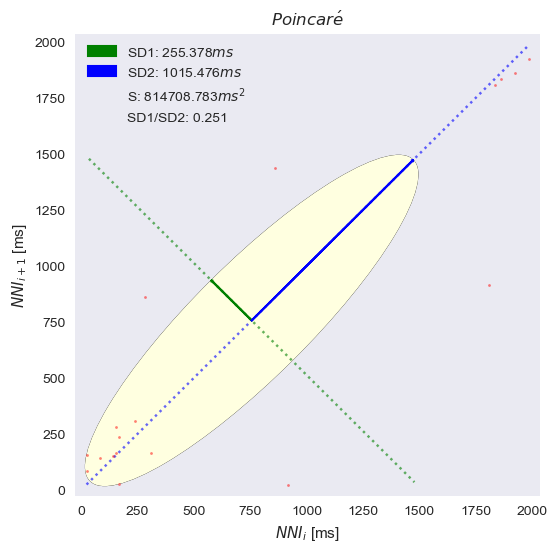

OSError: 'seaborn-darkgrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [556]:
# Poincare Plot
plt.close()
plot, result_dct1['SD1'], result_dct1['SD2'], result_dct1['SD1/SD2_Ratio'], result_dct1['S'] = nl.poincare(nn_ind)
#plt.title('Poincare Plot for RR-intervals') 
plot.savefig(filepath + datestr + "-JS-" + filename + "_RR_int_Poincare.png", format = "png")
plt.show()

# Welch Plot 
plt.close()
plt.style.use("seaborn-v0_8")
plot_psd(nn_ind)
#plt.show(plot_psd(nn_ind, method='welch'))
plt.savefig(filepath + datestr + "-JS-" + filename + "_RR_int_Welch_plot.png", format = "png")
plt.show()

## Filtering for Respiratory Data

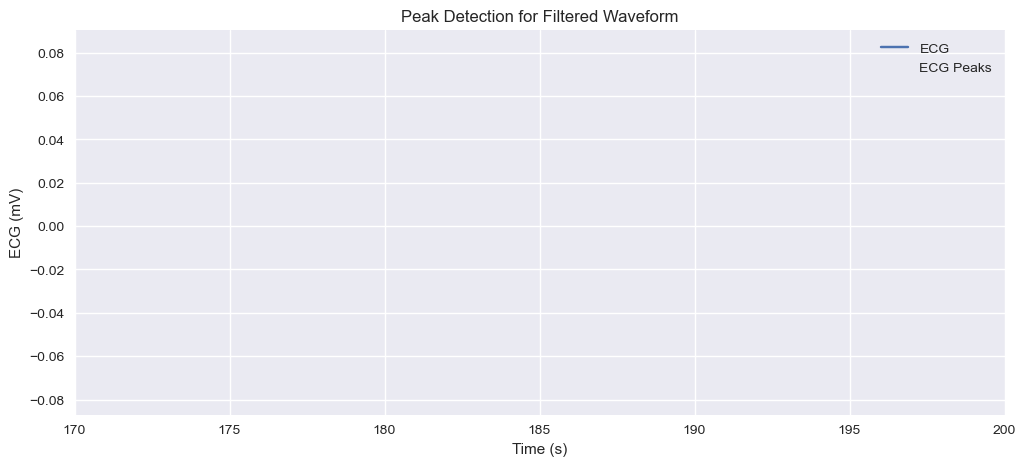

In [557]:
# Cardiac rate reference:
# Simultaneous monitoring of mouse respiratory and cardiac rates through a single precordial electrode (Sato et al., 2018)

# Notch filter at 60 Hz
b, a = signal.iirnotch(60.0, 30, fs)
ECG_BR = signal.filtfilt(b, a, ECG)

# Bandpass filter for respiratory power
Wn = [1.5, 5.5]  # Filter cutoff frequency, in Hz
d, c = butter(2, Wn, btype='bandpass', fs=fs)
ECG_BR = signal.filtfilt(d, c, ECG_BR)

# Finding breath widths filtered signal 
peaks_BR, properties = find_peaks(ECG_BR, prominence=.3, distance=20)

# Plot Original and Filtered ECG
plt.close()

plt.figure(figsize=(12,5))
plt.xlim(170, 200)  #xlim is in seconds
plt.plot(Time, ECG_BR)
plt.plot(Time[peaks_BR], ECG_BR[peaks_BR], "xr")
plt.legend(['ECG', 'ECG Peaks'])
plt.title("Peak Detection for Filtered Waveform")
plt.xlabel("Time (s)")
plt.ylabel("ECG (mV)")
plt.show()

## FFT CONVERSION AND PLOT

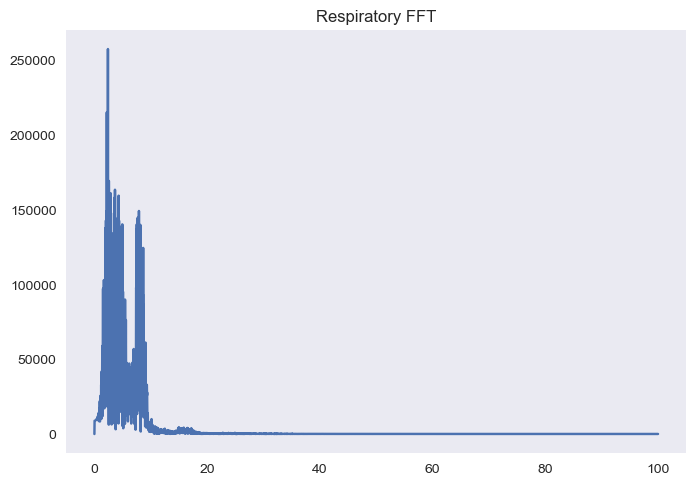

In [558]:
plt.close()
# Outlier removal
# Removes everything that's greater than a z-score of 3
# Requires your dataset to be detrended
# This method of outlier removal can be improved because it can result in false negatives
outliers_breath = len(ECG_BR) - len(ECG_BR[(np.abs(stats.zscore(ECG_BR)) < 3)])

# find_peaks arguments:
# This needs to be change to be more accurate, since currently it's just a guess
height_breath = ECG_BR.mean() + ((ECG_BR.max() - ECG_BR.min())/4) # Divide by 4 to account for lower amplitude peaks
distance_breath = 100 # 100 data points in between peaks should be enough to filter out smaller peaks
fft_data_br = np.subtract(ECG_BR,np.average(ECG_BR))
y_fft_br = fft(fft_data_br)
T = 1.0/fs
x_fft_br = fftfreq(N, T)[:N//2]
fft_breath_plt = plt.plot(x_fft_br, N * np.abs(y_fft_br[0:N//2]))
# exluding noise that is above 60 Hz (the mouse should not have heart rates above that)
plt.grid()
plt.title('Respiratory FFT')
plt.savefig(filepath + datestr + "-JS-" + filename + "_fft_breathing_plot.svg", format = "svg")
plt.show()

## Breath Width Analyses

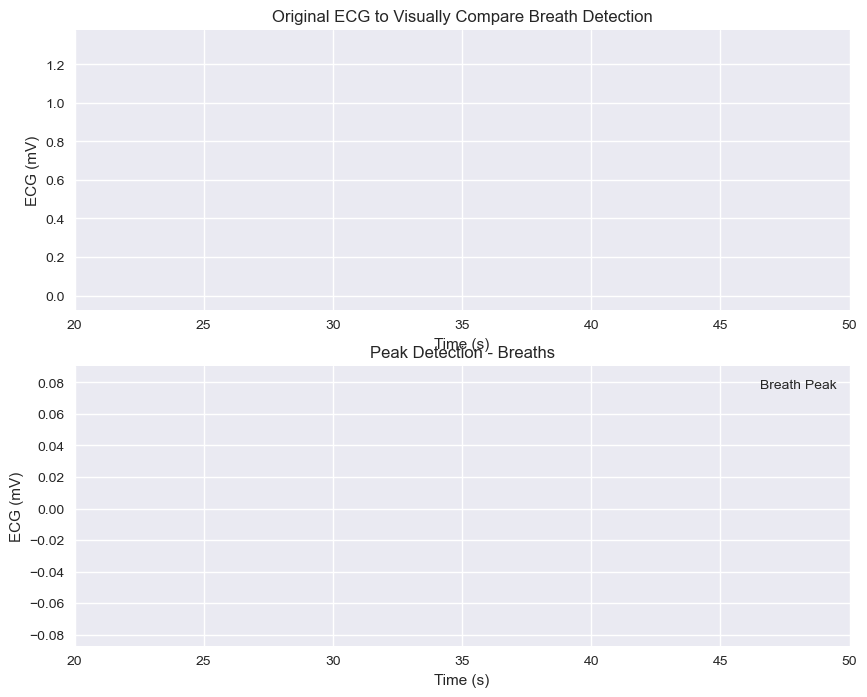

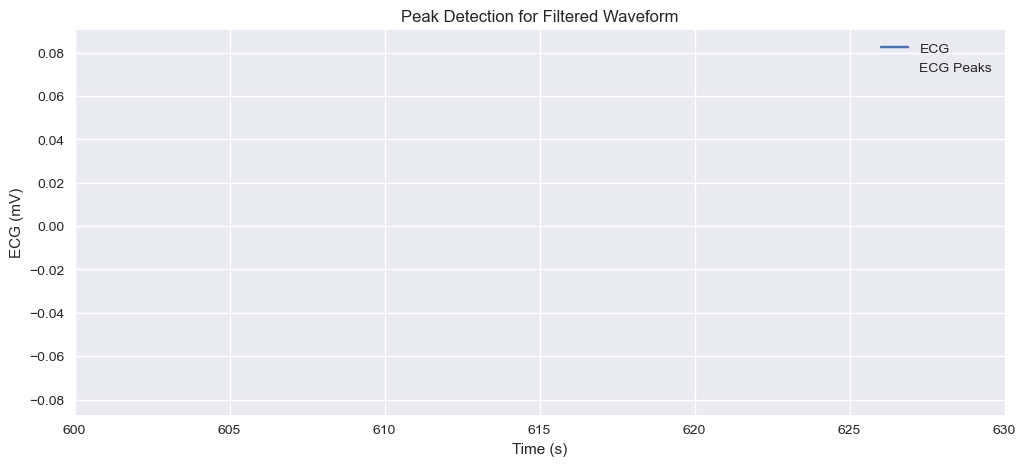

In [586]:
# FIND BREATH PEAKS
Breath_peaks, properties = find_peaks(ECG_BR, prominence=.041, distance=20)

# Find peak widths and add horizontal lines to show where they are being measured
widths, width_heights, left_ips, right_ips = peak_widths(ECG_BR, Breath_peaks, rel_height=0.65)

# Converts left/right values of width to Time scale 
left_Time = index_to_Time(Time, left_ips)
right_Time = index_to_Time(Time, right_ips)

bwidth = right_Time - left_Time # breath width
bwidth[bwidth < 0] = 0

# Find breath intervals, last value will be incorrect to keep array size consistent
x_shift = shift(left_Time, -1)
breath_int = (x_shift - right_Time)
breath_int[breath_int < 0] = 0

# Plot original to visually compare breath locations and ensure accuracy
plt.close()
fig4, ax4 = plt.subplots(2, 1, figsize=(10, 8))
custom_xlim_4 = (20, 50)
plt.setp(ax4, xlim=custom_xlim_4)

plt.subplot(2, 1, 1)
plt.plot(Time, ECG)
plt.title("Original ECG to Visually Compare Breath Detection")
plt.xlabel("Time (s)")
plt.ylabel("ECG (mV)")

# Plot breath peaks 
plt.subplot(2, 1, 2)
plt.plot(Time[peaks_BR], ECG_BR[peaks_BR], "xr")
plt.plot(Time, ECG_BR)
plt.hlines(width_heights, left_Time, right_Time, color="C2")
plt.title("Peak Detection - Breaths")
plt.legend(['Breath Peak'])
plt.xlabel("Time (s)")
plt.ylabel("ECG (mV)")
plt.show()

plt.close()

plt.figure(figsize=(12,5))
plt.xlim(600, 630)
plt.plot(Time, ECG_BR)
plt.plot(Time[Breath_peaks], ECG_BR[Breath_peaks], "xr")
plt.legend(['ECG', 'ECG Peaks'])
plt.title("Peak Detection for Filtered Waveform")
plt.xlabel("Time (s)")
plt.ylabel("ECG (mV)")
plt.show()

Time_peak_BR = pd.DataFrame(Time[peaks_BR], columns=["Time"])
ECG_peak_BR = pd.DataFrame(ECG_BR[peaks_BR], columns=["ECG (mV)"])
BI_df = pd.DataFrame(breath_int, columns=["Breathing Interval (s)"])
Int_start_df = pd.DataFrame(x_shift, columns=["Start of Breath n+1"])
Int_end_df = pd.DataFrame(right_Time, columns=["End of Breath n"])
BW_df = pd.DataFrame(bwidth, columns=["Breath Width (s)"])

BW_df = BW_df.mask(BW_df == 0)
BI_df = BI_df.mask(BI_df == 0)

## Respiratory Data Analysis

In [587]:
# Breath Width Analysis
arr_bw = widths.astype('float')
arr_bw = arr_bw[arr_bw != 0]
Time_peaks_bw = extract_features.get_time_domain_features(arr_bw)

breath_width = widths.copy()
z_score_breath = zscore(breath_width)
widths[np.abs(z_score_breath) > 3] = np.median(breath_width)
print('{} outliers were replaced with the median'.format(sum(map(lambda x,y: bool(x-y),widths,breath_width))))
ect_ind_bw = remove_ectopic_beats(breath_width)
nn_ind_bw = interpolate_nan_values(rr_intervals=ect_ind_bw)

## Breathing Interval Analysis
arr_BI = breath_int.astype('float')
arr_BI = arr_BI[arr_BI != 0]
Time_peaks_BI = extract_features.get_time_domain_features(arr_BI)

breath_ind = breath_int.copy()
z_score_breath = zscore(breath_ind)
breath_int[np.abs(z_score_breath) > 3] = np.median(breath_ind)
print('{} outliers were replaced with the median'.format(sum(map(lambda x,y: bool(x-y),breath_ind,breath_int))))
ect_ind_BI = remove_ectopic_beats(breath_int)
nn_ind_BI = interpolate_nan_values(rr_intervals=ect_ind_BI)

## ADJUSTING THE FREQUENCY BANDS TO WHAT HAS BEEN FOUND IN MICE

# NEED RESPIRATORY RATE FREQUENCIES FROM LITERATURE?
#freq_dom_dct_BI = extract_features.get_frequency_domain_features(breath_int, sampling_frequency = fs) 
#                                                  vlf_band = (.003, .4), 
#                                                  lf_band = (.4, 1.5), 
#                                                  hf_band = (1.5, 4))

#freq_dom_dct_bw = extract_features.get_frequency_domain_features(widths, sampling_frequency = fs) 
#                                                  vlf_band = (.003, .4), 
#                                                  lf_band = (.4, 1.5), 
#                                                  hf_band = (1.5, 4))

##CALCULATING ENTROPIES AND POINT CARE PLOT VALUES 
# breath width
#pcp_dct_bw = extract_features.get_poincare_plot_features(arr_bw)
#sampen_dct_bw = extract_features.get_sampen(arr_bw)
#nn6_bw, pnn6_bw = td.nnXX(nni = arr_bw, threshold = 6)
#nn6 and pnn6 because thats what it is for mice, needs to be double-checked form literature 
#nl_tuple_bw = nl.nonlinear(nni = arr_bw)
#ellipse_area_bw = nl_tuple_bw[4]
#sampen_bw = nl_tuple_bw[5]
#ShannEnt_bw = ent(nn_ind_bw)
#plt.close()

# breath intervals
#pcp_dct_BI = extract_features.get_poincare_plot_features(arr_BI)
#sampen_dct_BI = extract_features.get_sampen(arr_BI)
#nn6_BI, pnn6_BI = td.nnXX(nni = arr_BI, threshold = 6)
#nn6 and pnn6 because thats what it is for mice, needs to be double-checked form literature 
#nl_tuple_BI = nl.nonlinear(nni = arr_BI)
#ellipse_area_BI = nl_tuple_BI[4]
#sampen_BI = nl_tuple_BI[5]
#ShannEnt_BI = ent(nn_ind_BI)
#plt.close()

1 outliers were replaced with the median
34 ectopic beat(s) have been deleted with malik rule.
3 outliers were replaced with the median
48 ectopic beat(s) have been deleted with malik rule.


## Number of Breaths Detected

In [588]:
len(arr_BI)

109

## Dictionary storing Respiratory Data values output to CSV file

In [589]:
result_dct2 = {
# Breathing width results
            'BW_Height' : height_breath,
            'BW_Distance' : distance_breath,
            'BW_Raw_Zscore_Outliers' : outliers_breath,
            'No_of_Breaths' : len(arr_bw),
            'BW_Mean_NNI' : Time_peaks_bw['mean_nni'],
            'BW_Median_NNI' : Time_peaks_bw['median_nni'],
            #'BW_NN6' : nn6_bw,
            #'BW_PNN6' : pnn6_bw,
            'BW_SDNN' : Time_peaks_bw['sdnn'],
            'BW_SDSD' : Time_peaks_bw['sdsd'],
            'BW_RMSSD' : Time_peaks_bw['rmssd'],
            'BW_CVSD' : Time_peaks_bw['cvsd'],
            'BW_CVNNI' : Time_peaks_bw['cvnni'],
            'BW_Mean' : Time_peaks_bw['mean_hr'],
            'BW_Max' : Time_peaks_bw['max_hr'],
            'BW_Min' : Time_peaks_bw['min_hr'],
            'BW_SD' : Time_peaks_bw['std_hr'],
            #'BW_LF' : freq_dom_dct_BI['lf'],
            #'BW_HF' : freq_dom_dct_BI['hf'],
            #'BW_LF/HF_Ratio' : freq_dom_dct_BI['lf_hf_ratio'],
            #'BW_LFnu' : freq_dom_dct_BI['lfnu'],
            #'BW_HFnu' : freq_dom_dct_BI['hfnu'],
            #'BW_Total_Power' : freq_dom_dct_BI['total_power'],
            #'BW_VLF' : freq_dom_dct_BI['vlf'],
            #'BW_SD1' : pcp_dct_bw['sd1'],
            #'BW_SD2' : pcp_dct_bw['sd2'],
            #'BW_SD1/SD2_Ratio' : pcp_dct_bw['ratio_sd2_sd1'],
            #'BW_Ellipse_Area' : ellipse_area_bw,
            #'BW_SampEn' : sampen_bw,
            #'BW_ShannEn' : ShannEnt_bw,


# Breathing Interval Results

            'No_of_Breaths' : len(arr_BI),
            'BI_Mean_NNI' : Time_peaks_BI['mean_nni'],
            'BI_Median_NNI' : Time_peaks_BI['median_nni'],
            #'BI_NN6' : nn6_BI,
            #'BI_PNN6' : pnn6_BI,
            'BI_SDNN' : Time_peaks_BI['sdnn'],
            'BI_SDSD' : Time_peaks_BI['sdsd'],
            'BI_RMSSD' : Time_peaks_BI['rmssd'],
            'BI_CVSD' : Time_peaks_BI['cvsd'],
            'BI_CVNNI' : Time_peaks_BI['cvnni'],
            'BI_Mean' : Time_peaks_BI['mean_hr'],
            'BI_Max' : Time_peaks_BI['max_hr'],
            'BI_Min' : Time_peaks_BI['min_hr'],
            'BI_SD' : Time_peaks_BI['std_hr'],
            #'BW_LF' : freq_dom_dct_BI['lf'],
            #'BW_HF' : freq_dom_dct_BI['hf'],
            #'BW_LF/HF_Ratio' : freq_dom_dct_BI['lf_hf_ratio'],
            #'BW_LFnu' : freq_dom_dct_BI['lfnu'],
            #'BW_HFnu' : freq_dom_dct_BI['hfnu'],
            #'BW_Total_Power' : freq_dom_dct_BI['total_power'],
            #'BW_VLF' : freq_dom_dct_BI['vlf'],
            #'BI_SD1' : pcp_dct_BI['sd1'],
            #'BI_SD2' : pcp_dct_BI['sd2'],
            #'BI_SD1/SD2_Ratio' : pcp_dct_BI['ratio_sd2_sd1'],
            #'BI_Ellipse_Area' : ellipse_area_BI,
            #'BI_SampEn' : sampen_BI,
            #'BI_ShannEn' : ShannEnt_BI
            }

## Poincare and Welch Plots for Breathing Width and Intervals

<Figure size 800x550 with 0 Axes>

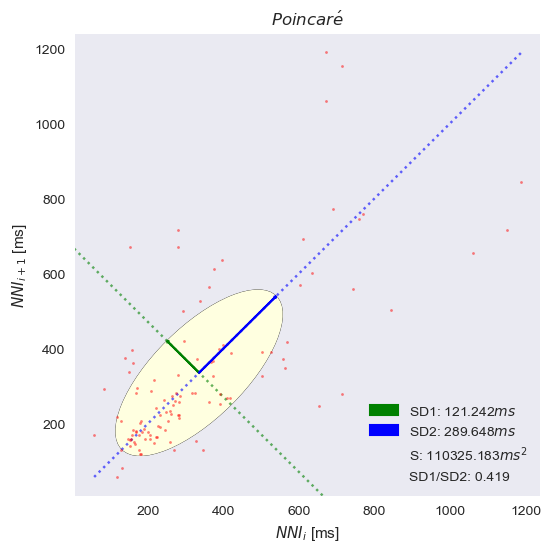

<Figure size 800x550 with 0 Axes>

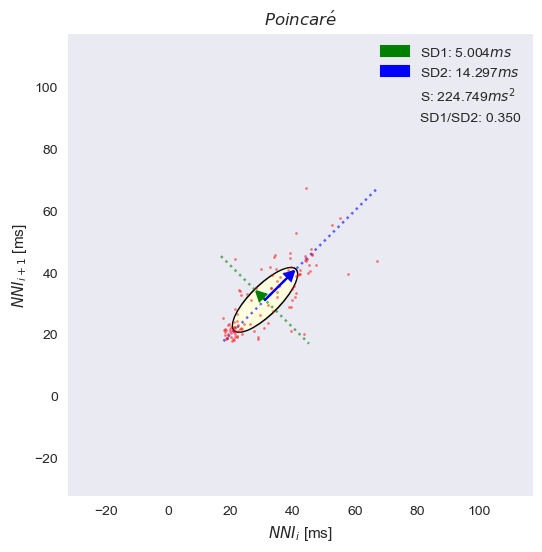

OSError: 'seaborn-darkgrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

<Figure size 800x550 with 0 Axes>

In [590]:
# Breathing intervals
plt.clf() 
plot, result_dct2['BI_SD1'], result_dct2['BI_SD2'], result_dct2['BI_SD1/SD2_Ratio'], result_dct2['S_BI'] = nl.poincare(nn_ind_BI) 
plot.savefig(filepath + datestr + "-" + filename + "_Poincare_Breathing_Intervals_plot.png", format = "png")

# Breathins widths
plt.clf()
plot, result_dct2['BW_SD1'], result_dct2['BW_SD2'], result_dct2['BW_SD1/SD2_Ratio'], result_dct2['S_BW'] = nl.poincare(nn_ind_bw) 
plot.savefig(filepath + datestr + "-" + filename + "_Poincare_Breathing_Widths_plot.png", format = "png")

## WELCH PLOTS

# Breathing intervals
plt.clf()
plot_psd(nn_ind_BI, method = "welch")  
plt.savefig(filepath + datestr + "-" + filename + "_Welch_breath_intervals_plot.png", format = "png")

# Breathing widths
plt.clf()
plot_psd(nn_ind_bw, method = "welch")  
plt.savefig(filepath + datestr + "-" + filename + "_Welch_breath_widths_plot.png", format = "png")

## Merging Dictionaries for CSV output

In [591]:
result_dct = result_dct1.copy()
result_dct.update(result_dct2)

df_dct_RR = pd.DataFrame([result_dct1]).transpose()
df_dct_BR = pd.DataFrame([result_dct2]).transpose()

## Outputting CSV File to Specified Directory

In [592]:
'''
# Export output file with Dictionary values 

# 'datestr' stores current date in YYYY-MM-DD- format
#datestr = time.strftime("%Y-%m-%d-")

# Specify path where you want file to be stored in 'filepath_out'
# If no folder is found, one is created and file is stored there; In this case 'Python_Output_Files'
filepath_out = 'C:\\Users\\vungo\\Desktop\\script_test\\test_output\\'

# CSV file created in 'filepath_out' with date appended to file name
csv_file = filepath_out + datestr + "-" + filename + '_results.csv'
#df = pd.DataFrame(result_dct)
#df = df.T
#df.to_csv(csv_file)
#print('Done')


fieldnames = [filename+'_Results', 'Value']
with open(csv_file, 'w') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for key, value in result_dct.items(): 
                csvfile.write('%s : %s\n' % (key, value))

print("File has been exported to specified directory")
'''

'\n# Export output file with Dictionary values \n\n# \'datestr\' stores current date in YYYY-MM-DD- format\n#datestr = time.strftime("%Y-%m-%d-")\n\n# Specify path where you want file to be stored in \'filepath_out\'\n# If no folder is found, one is created and file is stored there; In this case \'Python_Output_Files\'\nfilepath_out = \'C:\\Users\\vungo\\Desktop\\script_test\\test_output\\\'\n\n# CSV file created in \'filepath_out\' with date appended to file name\ncsv_file = filepath_out + datestr + "-" + filename + \'_results.csv\'\n#df = pd.DataFrame(result_dct)\n#df = df.T\n#df.to_csv(csv_file)\n#print(\'Done\')\n\n\nfieldnames = [filename+\'_Results\', \'Value\']\nwith open(csv_file, \'w\') as csvfile:\n            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)\n            writer.writeheader()\n            for key, value in result_dct.items(): \n                csvfile.write(\'%s : %s\n\' % (key, value))\n\nprint("File has been exported to specified directory")\n'

In [593]:
# Export output file with Dictionary values 

# 'datestr' stores current date in YYYY-MM-DD- format
#datestr = time.strftime("%Y-%m-%d-")

# Specify path where you want file to be stored in 'filepath_out'
# If no folder is found, one is created and file is stored there; In this case 'Python_Output_Files'
filepath_out = 'C:\\Users\\vungo\\Desktop\\EMG_Data_5-13-2025\\C57_S1S2\\python_output\\'

# CSV file created in 'filepath_out' with date appended to file name
csv_file = filepath_out + datestr + "-" + filename + '_results.xlsx'
#df = pd.DataFrame(result_dct)
#df = df.T
#df.to_csv(csv_file)
#print('Done')

with pd.ExcelWriter(csv_file, engine='xlsxwriter') as writer:
        df_dct_RR.to_excel(writer, sheet_name='Heart Rate Results')
        df_dct_BR.to_excel(writer, sheet_name='Respiratory Rate Results')
        Time_peak_RR.to_excel(writer, sheet_name='Heart Rate Results', startcol=4, index_label="R-peaks")
        ECG_peak_RR.to_excel(writer, sheet_name='Heart Rate Results', startcol=6, index=False)
        Time_peak_BR.to_excel(writer, sheet_name='Respiratory Rate Results', startcol=4, index_label="Breath Peak Index")
        ECG_peak_BR.to_excel(writer, sheet_name='Respiratory Rate Results', startcol=6, index=False)
        Int_start_df.to_excel(writer, sheet_name='Respiratory Rate Results', startcol=7, index=False)
        Int_end_df.to_excel(writer, sheet_name='Respiratory Rate Results', startcol=8, index=False)
        BI_df.to_excel(writer, sheet_name='Respiratory Rate Results', startcol=9, index=False)
        BW_df.to_excel(writer, sheet_name='Respiratory Rate Results', startcol=10, index=False)
        
print("File has been exported to specified directory")

File has been exported to specified directory


In [85]:
Breath_peaks

array([   18,   549,  1063,  1575,  2072,  2596,  3254,  3755,  4281,
        4843,  5430,  6029,  6557,  7134,  7651,  8113,  8555,  9043,
        9498,  9951, 10370, 10826, 11222, 11644, 12029, 12399],
      dtype=int64)